# Importing Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import os
import zipfile
import random
import shutil
import cv2
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
#Install kaggle API client
!pip install -q kaggle
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Downloading Dataset

In [ ]:
mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aditisatsangi/dataset-indian-vehicles
!unzip \*.zip && rm *.zip

100% 909M/913M [00:15<00:00, 95.8MB/s]
100% 913M/913M [00:15<00:00, 60.5MB/s]
Archive:  dataset-indian-vehicles.zip
  inflating: Vehicles./Vehicles/Auto/Thumbs.db  
  inflating: Vehicles./Vehicles/Auto/img 0100.PNG  
  inflating: Vehicles./Vehicles/Auto/img 0127.jpg  
  inflating: Vehicles./Vehicles/Auto/img 095.PNG  
  inflating: Vehicles./Vehicles/Auto/img 096.PNG  
  inflating: Vehicles./Vehicles/Auto/img 097.PNG  
  inflating: Vehicles./Vehicles/Auto/img 098.PNG  
  inflating: Vehicles./Vehicles/Auto/img 099.PNG  
  inflating: Vehicles./Vehicles/Auto/img 101.PNG  
  inflating: Vehicles./Vehicles/Auto/img 102.PNG  
  inflating: Vehicles./Vehicles/Auto/img 103.PNG  
  inflating: Vehicles./Vehicles/Auto/img 104.PNG  
  inflating: Vehicles./Vehicles/Auto/img 105.PNG  
  inflating: Vehicles./Vehicles/Auto/img 106.PNG  
  inflating: Vehicles./Vehicles/Auto/img 107.PNG  
  inflating: Vehicles./Vehicles/Auto/img 108.jpg  
  inflating: Vehicles./Vehicles/Auto/img 109.PNG  
  inflating: Vehi

In [ ]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)

# Training and Validation Dataset

In [ ]:
class_names = ['Auto', 'Bus','Car','Truck']
# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
   horizontal_flip=True,
   validation_split=0.2  # Split the dataset into training and validation
)

data = datagen.flow_from_directory(
   '/content/Vehicles./Vehicles',
   target_size=(224, 224),
   batch_size=BATCH_SIZE,
   #validation_split=0.2,
   subset='training',  # Specify 'training' to get the training subset
   seed=42,
   class_mode='categorical'  # Return class names as labels
)

class_names = data.class_indices

Found 2130 images belonging to 4 classes.


In [ ]:
class_indices = data.class_indices
print(class_indices)

{'Auto': 0, 'Bus': 1, 'Car': 2, 'Truck': 3}


In [ ]:
import os
import shutil

# Specify your image resolution and batch size
IMAGE_RES = 224
BATCH_SIZE = 32

# Define your data directory
data_dir = '/content/Vehicles./Vehicles'

# Create training, validation, and testing directories
train_dir = '/content/Vehicles./train'
val_dir = '/content/Vehicles./val'
test_dir = '/content/Vehicles./test'

# Create directories if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_folder in os.listdir(data_dir):
        os.makedirs(os.path.join(directory, class_folder), exist_ok=True)

# Function to split data into train, validation, and test sets
def split_data(class_folder, source, destination):
    files = os.listdir(os.path.join(source, class_folder))

    num_files = len(files)
    if num_files == 0:
        return

    train_split = int(0.8 * num_files)
    val_split = int(0.1 * num_files)

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    for file in train_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'train', class_folder, file))

    for file in val_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'val', class_folder, file))

    for file in test_files:
        shutil.move(os.path.join(source, class_folder, file), os.path.join(destination, 'test', class_folder, file))

# Move data to train, validation, and test directories
for class_folder in os.listdir(data_dir):
    split_data(class_folder, data_dir, '/content/Vehicles.')

# Now use flow_from_directory on the separate train, val, and test directories
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    seed=42
)

Found 2127 images belonging to 4 classes.
Found 264 images belonging to 4 classes.
Found 270 images belonging to 4 classes.


# Labelling dataset

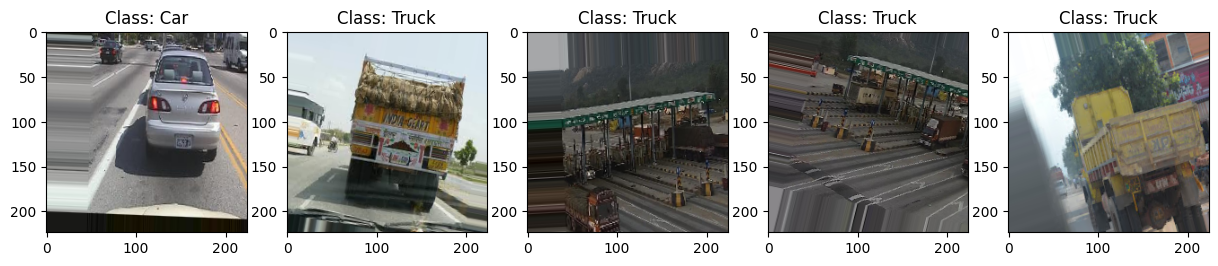

In [ ]:
import matplotlib.pyplot as plt

# Load the first batch of data (batch size = 32)
batch = next(data)

# Get the first 5 images and their one-hot encoded labels
images, one_hot_labels = batch[0][:5], batch[1][:5]

# Set the figure size for larger images
plt.figure(figsize=(15, 5))

# Iterate through the images and labels
for i in range(5):
    # Find the class index (1 in one-hot encoding)
    class_index = list(one_hot_labels[i]).index(1)

    # Get the class name from the class index
    class_name = list(data.class_indices.keys())[list(data.class_indices.values()).index(class_index)]

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Class: {class_name}')

plt.show()

In [ ]:
for i in range(1):  # Preview the first batch
    batch = next(data)
    images, labels = batch
    # Process or display the images and labels as needed
    print(labels)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
IMAGE_RES = 224
BATCH_SIZE = 32

# Using Pretrained Model ResNet

In [ ]:
# Load the ResNet50 model with pre-trained weights
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top (classification) layers
    weights='imagenet'  # Use pre-trained weights
)

# Unfreeze some layers in the base model for fine-tuning (optional)
for layer in base_model.layers:
    layer.trainable = True

# Modify the number of classes for the output layer based on your dataset
num_classes = len(class_names)  # Number of classes
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    output_layer  # Updated output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Display the model summary
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 23850500 (90.98 MB)
Trainable params: 23797

# Training Model

In [ ]:
batch_size=32
# Define the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // batch_size
val_steps_per_epoch = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)

Epoch 1/10
66/66 [==============================] - 1774s 27s/step - loss: 0.2430 - accuracy: 0.9104 - val_loss: 1.0702 - val_accuracy: 0.7422
Epoch 2/10
66/66 [==============================] - 1682s 25s/step - loss: 0.0626 - accuracy: 0.9781 - val_loss: 1.0799 - val_accuracy: 0.7344
Epoch 3/10
66/66 [==============================] - 1787s 27s/step - loss: 0.0397 - accuracy: 0.9886 - val_loss: 1.6513 - val_accuracy: 0.0566
Epoch 4/10
66/66 [==============================] - 1806s 27s/step - loss: 0.0365 - accuracy: 0.9890 - val_loss: 1.9758 - val_accuracy: 0.0684
Epoch 5/10
66/66 [==============================] - 1680s 25s/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 2.2019 - val_accuracy: 0.0547
Epoch 6/10
66/66 [==============================] - 1662s 25s/step - loss: 0.0318 - accuracy: 0.9905 - val_loss: 2.1535 - val_accuracy: 0.0566
Epoch 7/10
66/66 [==============================] - 1667s 25s/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 2.4606 - val_accuracy: 0.0449

# Accuracy

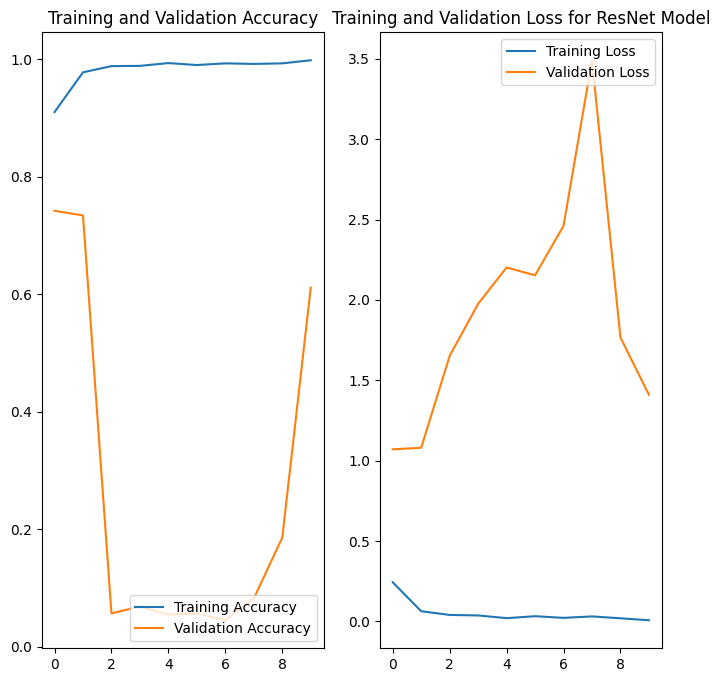

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS=10
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for ResNet Model')
plt.show()

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

print(f' Loss: {validation_loss:.4f}')
print(f' Accuracy: {validation_accuracy*100:.2f}%')

17/17 [==============================] - 114s 6s/step - loss: 1.4384 - accuracy: 0.6121
 Loss: 1.4384
 Accuracy: 61.21%


In [ ]:
test_loss,test_accuracy= model.evaluate(test_generator)
print("Loss: ",test_loss)
print("Test acccuracy: ",test_accuracy*100)

17/17 [==============================] - 107s 6s/step - loss: 1.4327 - accuracy: 0.5782
Loss:  1.4326684474945068
Test acccuracy:  57.815444469451904


In [ ]:
# Save the trained model
model.save('vehicle_classification_model_ResNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction

In [ ]:
class_names = ['Auto', 'Bus','Car','Truck']

1/1 [==============================] - 2s 2s/step
Predicted Class: (3, 'Truck')


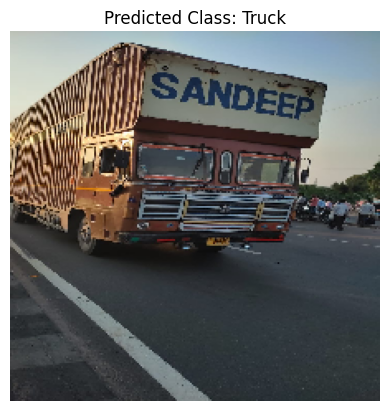

In [ ]:
img_path = '/content/Truck (1).jpg'
image_height = 224
image_width = 224
img = image.load_img(img_path, target_size=(image_height, image_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the class index with the highest predicted probability
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 194ms/step
Predicted Class: (2, 'Car')


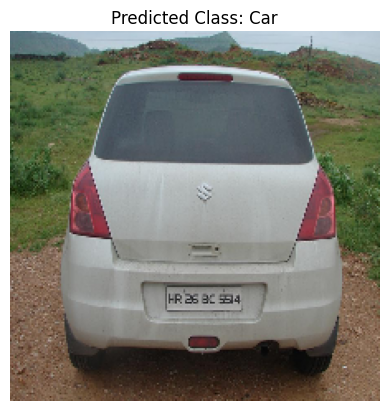

In [ ]:
img_path = '/content/img 095.PNG'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 198ms/step
Predicted Class: (0, 'Auto')


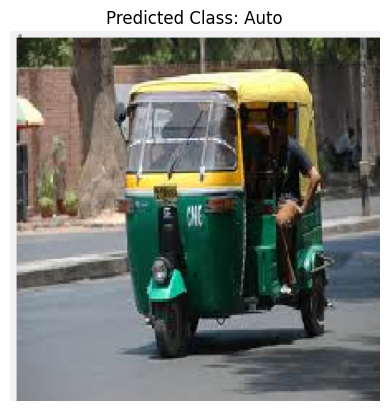

In [ ]:
img_path = '/content/img 128.PNG'
img = image.load_img(img_path, target_size=(image_height, image_width))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = keras.applications.inception_v3.preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(f'Predicted Class: {predicted_class_index,predicted_class_name}')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.imshow(img)
plt.axis('off')
plt.show()